# Modules

In [20]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, wilcoxon

from pdathome.constants import global_constants as gc, mappings as mp
from pdathome.evaluation import calculate_pvalue, plot_coefs, plot_significance

d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set_theme(style='ticks', rc=d_plot_params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [21]:
step = 'gait'
l_segment_categories = ['short', 'moderately_long', 'long', 'very_long']

# Load

In [22]:
d_performance = {
    gc.descriptives.PARKINSONS_DISEASE: {},
    gc.descriptives.CONTROLS: {}
}
for subject in gc.participant_ids.PD_IDS + gc.participant_ids.HC_IDS:
    if subject in gc.participant_ids.PD_IDS:
        population = gc.descriptives.PARKINSONS_DISEASE
    else:
        population = gc.descriptives.CONTROLS
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', step, f'{subject}.json'), 'r') as f:
        
        d_performance[population][subject] = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', step, 'logreg.json')) as f:
    d_coefs_logreg = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', step, 'rf.json')) as f:
    d_coefs_rf = json.load(f)

# Examine performance

## Feature coefficients

Logistic regression coefficients

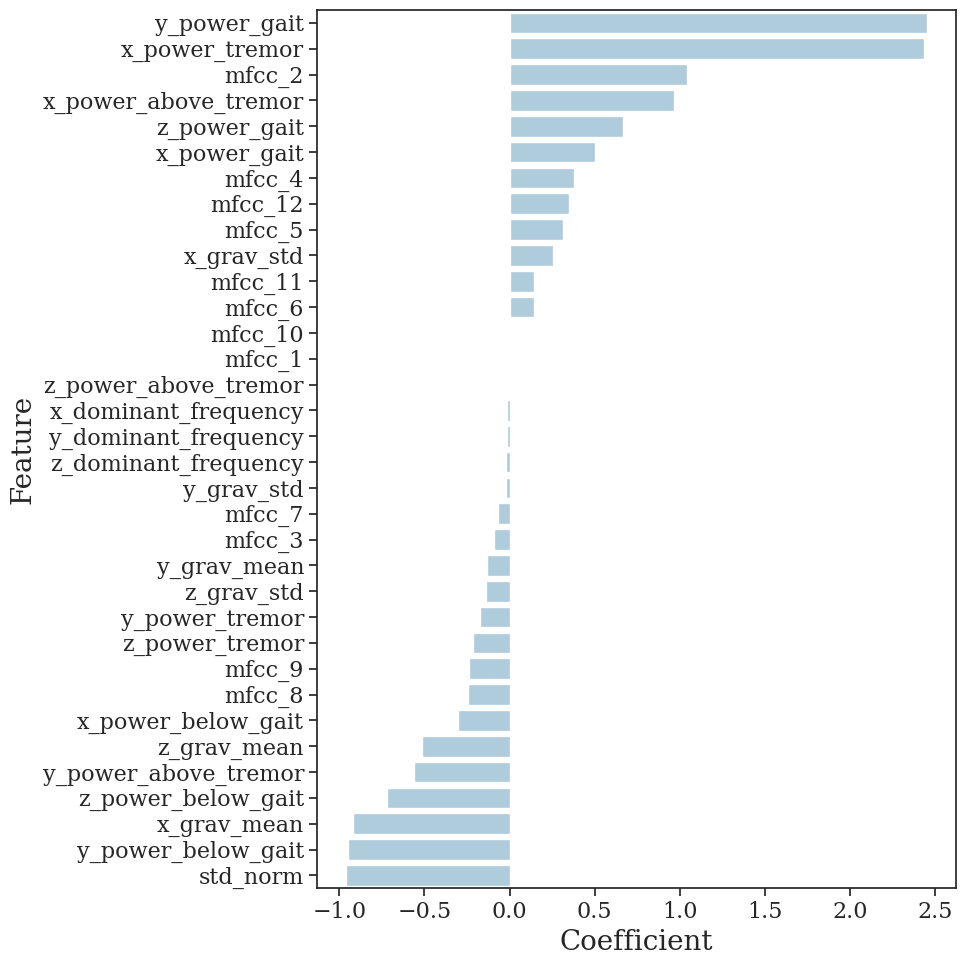

In [23]:
d_coefs_logreg = {k.replace('_accelerometer', '').replace('accelerometer_', '').replace('_acc', ''): v for k, v in d_coefs_logreg.items()}

plot_coefs(d_coefs=d_coefs_logreg, classifier=gc.classifiers.LOGISTIC_REGRESSION, figsize=(10,10))

Random forest impurity scores

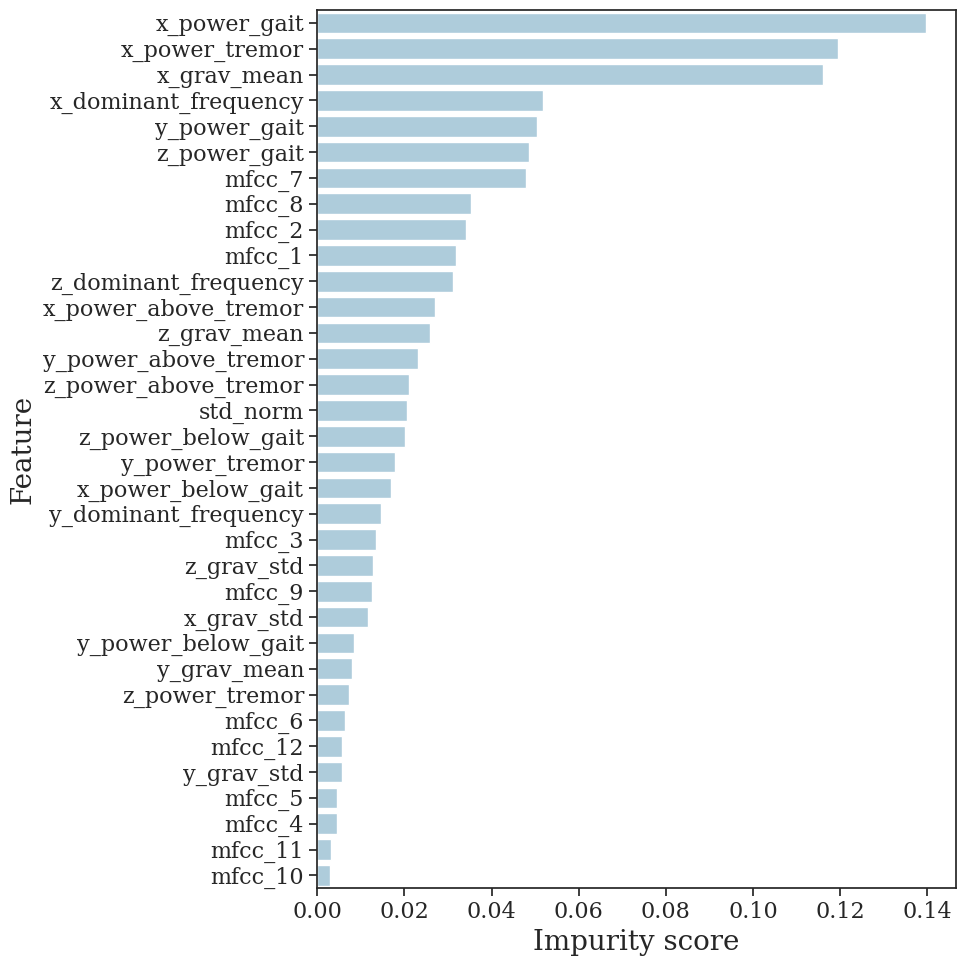

In [24]:
d_coefs_rf = {k.replace('_accelerometer', '').replace('accelerometer_', '').replace('_acc', ''): v for k, v in d_coefs_rf.items()}

plot_coefs(d_coefs=d_coefs_rf, classifier=gc.classifiers.RANDOM_FOREST, figsize=(10,10))

## Dataset size
#### Video-annotated gait

In [25]:
df_size = pd.DataFrame()

for (population, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.PRE_MED), (gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.POST_MED), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
    if population == gc.descriptives.PARKINSONS_DISEASE:
        l_ids = gc.participant_ids.PD_IDS
    else:
        l_ids = gc.participant_ids.HC_IDS

    for subject in l_ids:
        for segment_duration in [x for x in list(d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()) if x != 'non_gait']:
            segment_duration_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_true']

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                'pos',
                segment_duration,
                segment_duration_minutes
            ]).T], axis=0).reset_index(drop=True)

        for activity in ['pos', 'neg']:

            total_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'ann_{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)


df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],2)} ({np.round(x['std'],2)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Annotated activity', 'Annotated segment duration', 'Mean (SD) number of minutes']

print(f"Minutes of annotated gait stratified by annotated segment duration.")
df_size_grouped.set_index(['Population', 'Annotated activity', 'Annotated segment duration'])

Minutes of annotated gait stratified by annotated segment duration.


Mean (SD) number of minutes
Population Annotated activity Annotated segment duration                            
PD pre     pos                short                                      0.88 (0.46)
                              moderately_long                            1.78 (0.82)
                              long                                       1.85 (0.84)
                              very_long                                   9.3 (5.78)
           neg                total                                    77.89 (15.47)
           pos                total                                     13.81 (5.93)
                              nan                                          0.0 (0.0)
PD post    pos                short                                      0.53 (0.33)
                              moderately_long                             1.25 (0.5)
                              long                                       1.06 (0.65)
                              very_long                                  8.84 (5.43)
           neg                total                                    45.45 (16.52)
           pos                total                                     11.58 (5.71)
                              nan                                          0.0 (0.0)
HC         pos                short                                       1.7 (0.64)
                              moderately_long                            2.28 (0.76)
                              long                                       1.76 (1.38)
                              very_long                                 14.32 (5.53)
           neg                total                                    75.39 (15.55)
           pos                total                                     20.06 (6.56)
                              nan                                          0.0 (0.0)

#### Predicted gait

In [26]:
df_size = pd.DataFrame()
decimals = 1

for (population, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.PRE_MED), (gc.descriptives.PARKINSONS_DISEASE, gc.descriptives.POST_MED), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
    if population == gc.descriptives.PARKINSONS_DISEASE:
        l_ids = gc.participant_ids.PD_IDS
    else:
        l_ids = gc.participant_ids.HC_IDS

    for subject in l_ids:
        for segment_duration in d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys():
            segment_duration_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_pred']

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                'pos',
                segment_duration,
                segment_duration_minutes
            ]).T], axis=0).reset_index(drop=True)

        for activity in ['pos', 'neg']:
            total_minutes = d_performance[population][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'pred_{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)

df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],decimals)} ({np.round(x['std'],decimals)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Activity', 'Annotated segment duration', 'Mean (SD) number of minutes']

print(f"Minutes of predicted gait stratified by annotated segment duration.")
df_size_grouped.set_index(['Population', 'Annotated segment duration'])

Minutes of predicted gait stratified by annotated segment duration.


Activity Mean (SD) number of minutes
Population Annotated segment duration                                     
PD pre     short                           pos                   0.6 (0.4)
           moderately_long                 pos                   1.5 (0.8)
           long                            pos                   1.5 (0.7)
           very_long                       pos                   8.9 (5.7)
           total                           neg                 75.2 (14.6)
           total                           pos                  16.5 (6.7)
           nan                             pos                   4.1 (2.4)
PD post    short                           pos                   0.4 (0.3)
           moderately_long                 pos                   1.1 (0.5)
           long                            pos                   1.0 (0.6)
           very_long                       pos                   8.7 (5.5)
           total                           neg                 42.1 (15.7)
           total                           pos                  14.9 (7.3)
           nan                             pos                   3.8 (2.7)
HC         short                           pos                   1.4 (0.5)
           moderately_long                 pos                   2.1 (0.7)
           long                            pos                   1.6 (1.3)
           very_long                       pos                  14.2 (5.5)
           total                           neg                 62.9 (15.4)
           total                           pos                 32.5 (10.4)
           nan                             pos                  12.7 (6.5)

## General performance
Split by population (PD, HC) and medication state for PD (pre-med, post-med)

In [27]:
df_performance = pd.DataFrame()

for gd_model in [gc.classifiers.LOGISTIC_REGRESSION, gc.classifiers.RANDOM_FOREST]:
    for (pop, med_stage) in [(gc.descriptives.PARKINSONS_DISEASE, 'pre'), (gc.descriptives.PARKINSONS_DISEASE, 'post'), (gc.descriptives.CONTROLS, gc.descriptives.CONTROLS)]:
        if pop == gc.descriptives.PARKINSONS_DISEASE:
            l_subjects = gc.participant_ids.PD_IDS
            pop_medstage = f"{pop}_{med_stage}"
        else:
            l_subjects = gc.participant_ids.HC_IDS
            pop_medstage = pop

        sens = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] for x in l_subjects]
        spec = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'] for x in l_subjects]
        bacc = [(x+y)/2 for x,y in zip(sens, spec)]
        auc = [d_performance[pop][x][gd_model][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['auc'] for x in l_subjects]

        df_performance = pd.concat([df_performance, pd.DataFrame([gd_model,
                                                                  pop_medstage,
                                                                  f"{np.round(np.mean(bacc),2)} ({np.round(np.std(bacc),2)})",
                                                                  f"{np.round(np.mean(sens),2)} ({np.round(np.std(sens),2)})",
                                                                  f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                                                  f"{np.round(np.mean(auc),2)} ({np.round(np.std(auc),2)})"
                                                                 ]).T], axis=0).reset_index(drop=True)
        
            
df_performance.columns = ['Classifier', 'Population', 'Balanced accuracy', 'Sensitivity', 'Specificity', 'AUC']

for med_stage in ['pre', 'post']:
    rf_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.PD_IDS]
    logreg_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.PD_IDS]

    print(f"*PD {med_stage}-med* random forest vs. logistic regression balanced accuracy: p = {wilcoxon(rf_bacc, logreg_bacc)[1]}")

df_performance.pivot(index='Population', columns='Classifier', values=['Sensitivity', 'Specificity', 'AUC']).sort_index(ascending=False)

*PD pre-med* random forest vs. logistic regression balanced accuracy: p = 1.9073486328125e-06
*PD post-med* random forest vs. logistic regression balanced accuracy: p = 0.0062808990478515625


Sensitivity               Specificity                       AUC  \
Classifier       logreg           rf       logreg           rf       logreg   
Population                                                                    
PD_pre       0.83 (0.1)  0.89 (0.09)  0.96 (0.03)  0.95 (0.03)  0.98 (0.02)   
PD_post     0.88 (0.09)  0.95 (0.05)  0.94 (0.04)  0.91 (0.05)  0.98 (0.01)   
HC          0.92 (0.03)  0.96 (0.02)  0.88 (0.06)  0.82 (0.09)  0.97 (0.01)   

                         
Classifier           rf  
Population               
PD_pre      0.98 (0.01)  
PD_post     0.99 (0.01)  
HC          0.98 (0.01)

In [28]:
for med_stage in ['pre']:
    rf_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.PD_IDS]
    logreg_bacc = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['spec'])/2 for x in gc.participant_ids.PD_IDS]

In [29]:
metric = 'sens'

metric_pre = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][metric] for x in gc.participant_ids.PD_IDS]
metric_post = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][metric] for x in gc.participant_ids.PD_IDS]
metric_controls = [d_performance[gc.descriptives.CONTROLS][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS][metric] for x in gc.participant_ids.HC_IDS]

In [30]:
metric = 'sens'
metric_mas = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][metric] for x in gc.participant_ids.PD_IDS]
metric_las = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][gc.descriptives.LEAST_AFFECTED_SIDE][gc.descriptives.PRE_MED][metric] for x in gc.participant_ids.PD_IDS]

In [31]:
side = 'MAS'
decimals = 2

for subject in gc.participant_ids.PD_IDS:
    pre_sens = np.round(d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][side]['pre']['sens'], decimals)
    pre_spec = np.round(d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][side]['pre']['spec'], decimals)
    post_sens = np.round(d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][side]['post']['sens'], decimals)
    post_spec = np.round(d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][side]['post']['spec'], decimals)
    print(subject, side, pre_sens, pre_spec, post_sens, post_spec)

hbv002 MAS 0.89 0.96 0.95 0.95
hbv012 MAS 0.85 0.9 0.88 0.9
hbv014 MAS 0.91 0.95 0.92 0.96
hbv015 MAS 0.87 0.93 0.99 0.89
hbv016 MAS 0.91 0.96 0.93 0.95
hbv017 MAS 0.86 0.93 0.97 0.96
hbv022 MAS 0.94 0.97 0.97 0.86
hbv024 MAS 0.94 0.96 0.97 0.96
hbv039 MAS 0.95 0.97 0.99 0.96
hbv043 MAS 0.87 0.97 0.96 0.95
hbv054 MAS 0.8 0.97 0.8 0.95
hbv065 MAS 0.92 0.97 0.9 0.97
hbv077 MAS 0.97 0.96 0.99 0.77
hbv079 MAS 0.94 0.91 0.97 0.86
hbv090 MAS 0.92 0.97 0.99 0.84
hbv013 MAS 0.71 0.97 0.87 0.94
hbv018 MAS 0.97 0.88 0.99 0.91
hbv023 MAS 0.96 0.92 0.99 0.91
hbv038 MAS 0.59 0.95 0.94 0.89
hbv058 MAS 0.9 0.98 0.98 0.96
hbv063 MAS 0.9 0.93 0.95 0.87


## Effect of behavior

Effect of activities on the specificity of the classifier

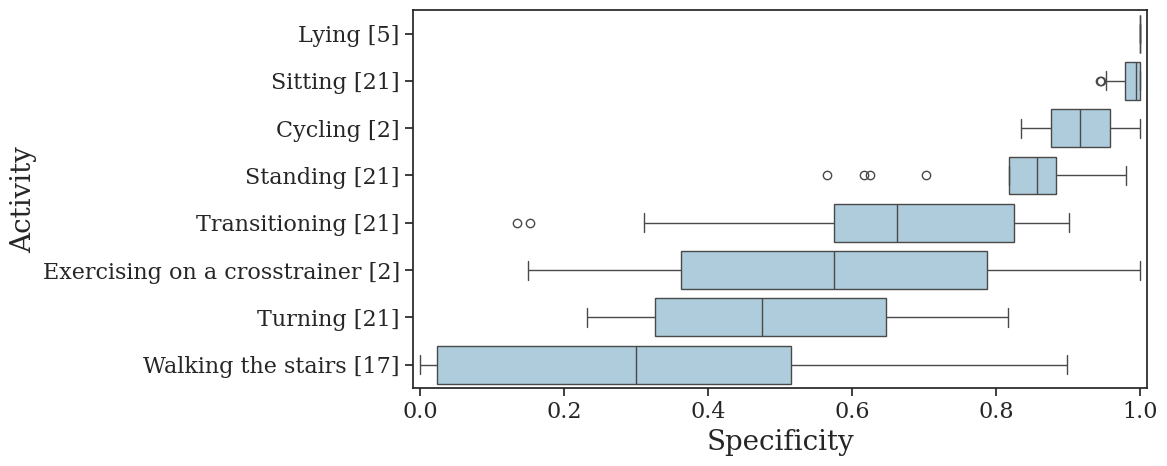

In [32]:
l_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities'].keys()) for x in gc.participant_ids.PD_IDS] for x in y if x != 'Walking']))

d_activity_performance = {}

for activity in l_activities:
    key_name = 'Lying' if activity == 'Laying' else activity
    d_activity_performance[key_name] = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities'][activity]['spec'] for x in gc.participant_ids.PD_IDS if activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['activities']]

    # print(f"{activity}: {np.round(np.mean(d_activity_performance[activity]),2)} +/- {np.round(np.std(d_activity_performance[activity]),2)}")

d_activity_performance = {f'{k} [{len(d_activity_performance[k])}]': v for k, v in sorted(d_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

fig, ax = plt.subplots(figsize=(12, 5))

sns.boxplot(data=d_activity_performance, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, orient='h')

# plot_n_subjects(d_performance=d_activity_performance, x_loc=1.015, y_loc=1.2, ax=ax)

ax.set_xlim([-0.01, 1.01])
ax.set_xlabel('Specificity')
ax.set_ylabel('Activity')
# 'Specificity of activities')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Effect of arm activities during gait on the sensitivity of the classifier

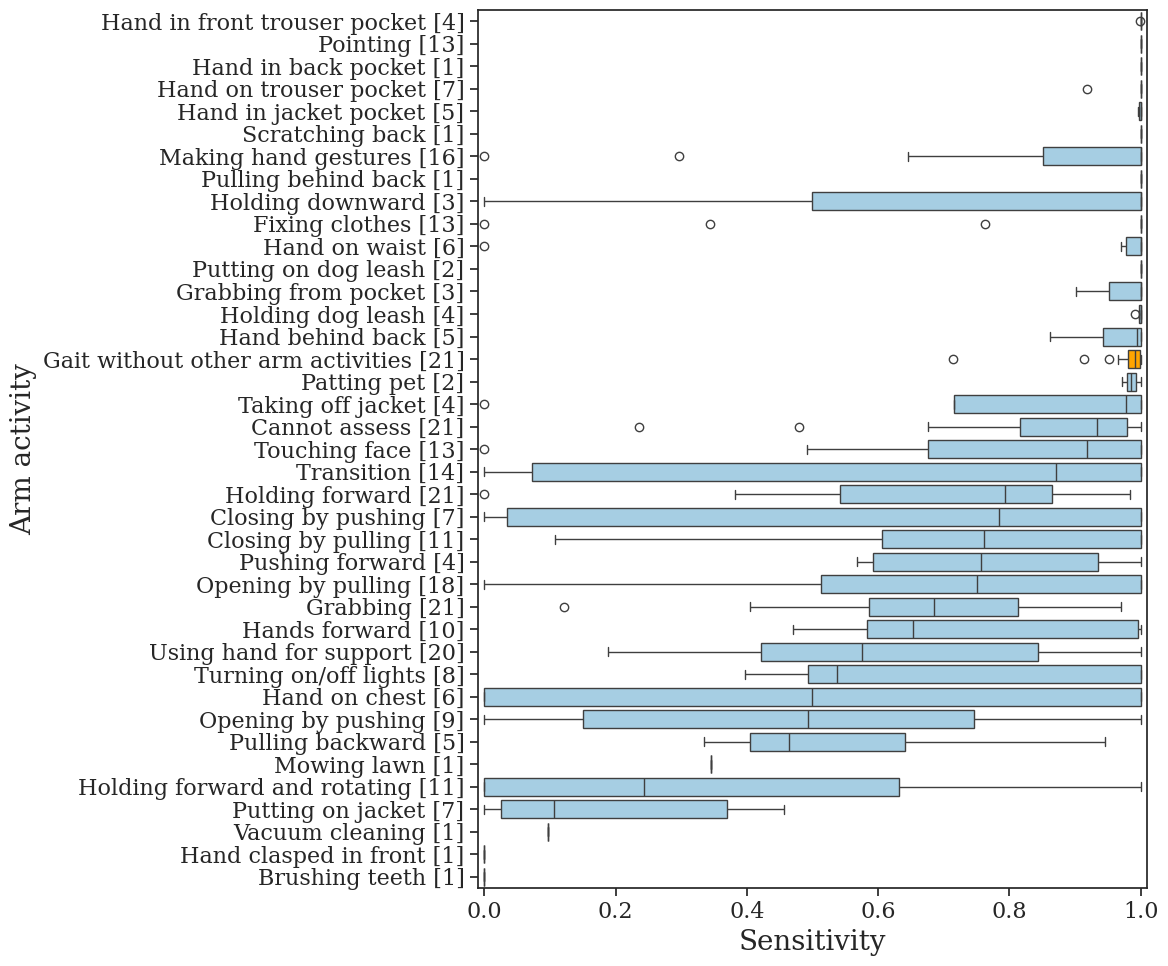

In [33]:
l_arm_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities'].keys()) for x in gc.participant_ids.PD_IDS] for x in y]))

l_arm_activities = [x for x in l_arm_activities if x != 'Not gait']

d_arm_activity_performance = {}

for arm_activity in l_arm_activities:
    l_sens = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities'][arm_activity]['sens'] 
        for x in gc.participant_ids.PD_IDS 
        if arm_activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['arm_activities']]
    
    if arm_activity == 'Gait without other arm movements':
        arm_activity = 'Gait without other arm activities'

    d_arm_activity_performance[arm_activity] = l_sens

d_arm_activity_performance = {k: v for k, v in sorted(d_arm_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

# Find the index of the label to color
target_label = "Gait without other arm activities"
target_index = list(d_arm_activity_performance.keys()).index(target_label)

d_arm_activity_performance = {f'{k} [{len(d_arm_activity_performance[k])}]': v for k, v in d_arm_activity_performance.items()}

fig, ax = plt.subplots(figsize=(12, 10))

boxplot = sns.boxplot(data=d_arm_activity_performance, ax=ax, orient='h')

# Get the index of the target label and set box color
for i, patch in enumerate(ax.patches):
    if i == target_index:
        patch.set_facecolor('orange')
    else:
        patch.set_facecolor(gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)

# plot_n_subjects(d_performance=d_arm_activity_performance, x_loc=1.015, y_loc=1.4, ax=ax)

ax.set_xlim([-0.01, 1.01])
ax.set_xlabel('Sensitivity')
ax.set_ylabel('Arm activity')
# ax.set_title('Sensitivity of arm activities')

plt.tight_layout()
plt.show()

Effect of gait sequence duration on the sensitivity of the classifier

Sensitivity per Segment duration
short: 0.63 +/- 0.18
moderately_long: 0.82 +/- 0.13
long: 0.77 +/- 0.17
very_long: 0.95 +/- 0.13


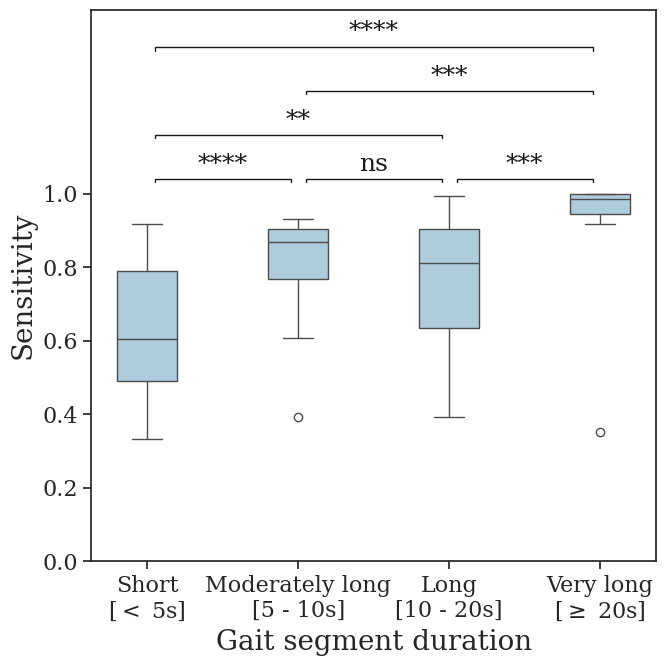

In [34]:
new_xtick_labels = [mp.segment_rename[x].replace(' [', '\n[') for x in l_segment_categories]

d_segment_performance = {}

d_segment_classes = {
    '0': 'short',
    '1': 'moderately_long',
    '2': 'long',
    '3': 'very_long',
}

d_comparisons_per_row = {
    '1': [[0, 1], [1, 2], [2, 3]],
    '2': [[0, 2]],
    '3': [[1, 3]],
    '4': [[0, 3]]
}

print("Sensitivity per Segment duration")
for segment_duration in l_segment_categories:
    d_segment_performance[segment_duration] = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
        [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
        [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
        [f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens'] 
        for x in gc.participant_ids.PD_IDS 
        if segment_duration in (
            d_performance[gc.descriptives.PARKINSONS_DISEASE][x]
            [gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED]
            [gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]
            [f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()
        )
    ]

    print(f"{segment_duration}: {np.round(np.mean(d_segment_performance[segment_duration]),2)} +/- {np.round(np.std(d_segment_performance[segment_duration]),2)}")

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=d_segment_performance, width=0.4, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)

for row, comparisons in d_comparisons_per_row.items():
    for comparison in comparisons:
        vals_1 = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][d_segment_classes[str(comparison[0])]]['sens'] for x in gc.participant_ids.PD_IDS]
        vals_2 = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][d_segment_classes[str(comparison[1])]]['sens'] for x in gc.participant_ids.PD_IDS]
        pvalue = calculate_pvalue(vals_1, vals_2, 'wilcoxon')[1]
        plot_significance(ax, comparison[0]+0.05, comparison[1]-0.05, pvalue, 1, 0.12, int(row), d_plot_params['font.size'])


ax.set_ylim([0, 1.5])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Gait segment duration')
# ax.set_title('Gait detection sensitivity\nper Segment duration')
ax.set_xticks(ax.get_xticks(), new_xtick_labels)

ax.set_yticks(ax.get_yticks()[0:-3])

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PD pre-med vs post-med after correcting for sequence duration and arm activities

System: uncorrected - p-value: 1.33514404296875e-05
System: corrected - p-value: 0.945744514465332


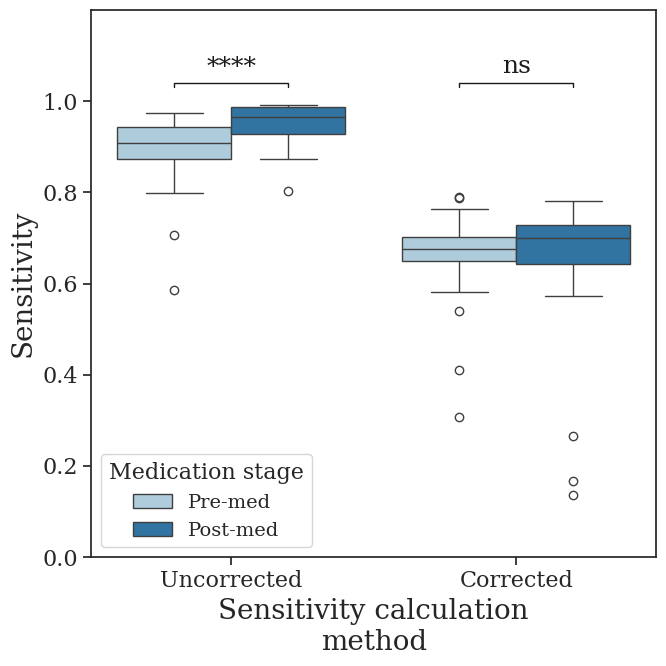

In [35]:
df_arm_activity = pd.DataFrame()
df_uncorrected = pd.DataFrame()

# Collect data for each subject
for subject in gc.participant_ids.PD_IDS:
    for med_stage in ['pre', 'post']:
        for segment_duration in mp.segment_rename.keys():
            try:
                d_focus = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]
            except KeyError:
                continue
            else:
                for arm_activity in d_focus['arm_activities'].keys():
                    mins = d_focus['arm_activities'][arm_activity]['minutes']
                    sens = d_focus['arm_activities'][arm_activity]['sens']
                    df_arm_activity = pd.concat([df_arm_activity, pd.DataFrame([mins, sens, segment_duration, arm_activity, subject, med_stage], 
                                              index=['mins', 'sens', f'{gc.columns.TRUE_SEGMENT_CAT}_duration', gc.columns.ARM_LABEL, gc.columns.ID, gc.columns.PRE_OR_POST]).T])
        
        sens_uncorrected = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.RANDOM_FOREST][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['sens']
        df_uncorrected = pd.concat([df_uncorrected, pd.DataFrame([sens_uncorrected, subject, med_stage]).T])

df_uncorrected.columns = ['sens', gc.columns.ID, gc.columns.PRE_OR_POST]
df_uncorrected['system'] = 'uncorrected'

# Calculate corrected sensitivities
df_corrected_sens = df_arm_activity.copy()

# Calculate corrected prevalence
df_corrected_prevalence = df_arm_activity.groupby([gc.columns.ARM_LABEL, f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])['mins'].sum().reset_index()
df_corrected_prevalence['prop_corrected'] = df_corrected_prevalence['mins'] / df_corrected_prevalence['mins'].sum()

# Merge corrected prevalence into corrected sensitivities
df_corrected = df_corrected_sens.merge(df_corrected_prevalence[[gc.columns.ARM_LABEL, f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'prop_corrected']], 
                                            how='left', 
                                            on=[gc.columns.ARM_LABEL, f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])

# Initialize dataframe containing corrected and uncorrected values
df_complete = pd.DataFrame()

# Calculate sensitivity for the corrected method
for stage in ['pre', 'post']:
    df_stage = df_corrected.loc[df_corrected[gc.columns.PRE_OR_POST] == stage]
    for subject in gc.participant_ids.PD_IDS:
        df_subject = df_stage.loc[df_stage[gc.columns.ID] == subject]
        if df_subject.shape[0] > 0:
            # Uncorrected sensitivities
            uncorrected_sens = df_uncorrected.loc[(df_uncorrected[gc.columns.PRE_OR_POST] == stage) & (df_uncorrected[gc.columns.ID] == subject), 'sens'].values
            uncorrected_entry = pd.DataFrame([[stage, subject, 'uncorrected', np.mean(uncorrected_sens) if uncorrected_sens.size > 0 else 0]], 
                                       columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens'])
            df_complete = pd.concat([df_complete, uncorrected_entry], ignore_index=True)

            # Corrected sensitivity calculation
            corrected_sens = np.sum(np.multiply(df_subject['sens'], df_subject['prop_corrected']))
            corrected_entry = pd.DataFrame([[stage, subject, 'corrected', corrected_sens]], 
                                           columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens'])
            df_complete = pd.concat([df_complete, corrected_entry], ignore_index=True)

# Set column names for df_corrected
df_complete.columns = [gc.columns.PRE_OR_POST, gc.columns.ID, 'system', 'sens']

# Drop IDs that are missing either pre or post
l_drop_ids = [x for x in df_complete.loc[df_complete[gc.columns.PRE_OR_POST] == 'pre', gc.columns.ID].unique() if x not in df_complete.loc[df_complete[gc.columns.PRE_OR_POST] == 'post', gc.columns.ID].unique()]
df_complete = df_complete.loc[~df_complete[gc.columns.ID].isin(l_drop_ids)]

# Plotting
fig, ax = plt.subplots(figsize=(7,7))

# Define the order for systems
order = ['uncorrected', 'corrected']

sns.boxplot(data=df_complete, x='system', y='sens', hue=gc.columns.PRE_OR_POST, order=order, palette=gc.plot_parameters.COLOR_PALETTE)

for j, system in enumerate(order):
    vals_pre = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'pre'), 'sens'].values)
    vals_post = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'post'), 'sens'].values)

    # Assuming calculate_pvalue and plot_significance are functions already defined
    pvalue = calculate_pvalue(vals_pre, vals_post, 'wilcoxon')[1]
    plot_significance(ax=ax, x_min=j + 0.2, x_max=j - 0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system} - p-value: {pvalue}")

ax.set_ylim([0, 1.2])
ax.set_xticks(ax.get_xticks(), ['Uncorrected', 'Corrected'])
# ax.set_title('Sensitivity with and without correction')
ax.set_xlabel('Sensitivity calculation\nmethod')
ax.set_ylabel('Sensitivity')

# Customize legend and axis tick visibility
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=['Pre-med', 'Post-med'], title='Medication stage')

ax.set_yticks(ax.get_yticks()[0:-1])


fig.tight_layout()
plt.show()


## Effect of PD

In [36]:
import datetime

for subject in gc.participant_ids.PD_IDS:
    df_patient_info = pd.read_pickle(os.path.join(gc.paths.PATH_CLINICAL_DATA, 'df_patient_info_updrs_3.pkl'))
    df_subject = df_patient_info.loc[df_patient_info['record_id']==subject]

    age = int(datetime.datetime.now().year - df_subject['year_of_birth'].iloc[0])
    ysd = int(datetime.datetime.now().year - df_subject['year_diagnosis'].iloc[0])
    gender = 'male' if df_subject['gender'].iloc[0] == 1 else 'female'

    d_clinical_scores = {}

    d_clinical_scores['updrs'] = {}
    for med_stage, med_prefix in zip([gc.descriptives.PRE_MED, gc.descriptives.POST_MED], ['OFF', 'ON']):
        d_clinical_scores['updrs'][med_stage] = {}
        for side in ['right', 'left']:
            if subject in gc.participant_ids.PD_MOST_AFFECTED_RIGHT:
                if side == 'right':
                    affected_side = gc.descriptives.MOST_AFFECTED_SIDE
                else:
                    affected_side = gc.descriptives.LEAST_AFFECTED_SIDE
            else:
                if side == 'left':
                    affected_side = gc.descriptives.MOST_AFFECTED_SIDE
                else:
                    affected_side = gc.descriptives.LEAST_AFFECTED_SIDE

            updrs_3_hypokinesia_stage_cols = [f'{med_prefix}_{x}' for x in mp.updrs_3_map[side]['hypokinesia'].keys()]
            updrs_3_stage_cols = updrs_3_hypokinesia_stage_cols + [f'{med_prefix}_{x}' for x in mp.updrs_3_map[side]['tremor'].keys()]
            
            d_clinical_scores['updrs'][med_stage][affected_side] = {
                'subscore': np.sum(df_subject[updrs_3_hypokinesia_stage_cols], axis=1).values[0],
                'total': np.sum(df_subject[updrs_3_stage_cols], axis=1).values[0]
            }

In [37]:
df_segment_subscore = pd.DataFrame()

for subject in gc.participant_ids.PD_IDS:
    subscore = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject]['clinical']['updrs'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['subscore']
    for segment_duration in [x for x in l_segment_categories if x in d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()]:
        sens = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['sens']
        df_segment_subscore = pd.concat([df_segment_subscore, pd.DataFrame([subscore, segment_duration, sens, subject], index=['subscore', f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'sens', gc.columns.ID]).T])

df_segment_subscore['subscore'] = df_segment_subscore['subscore'].astype(int)
df_segment_subscore['sens'] = df_segment_subscore['sens'].astype(float)

Spearman correlation between subscore and sensitivity for ...

... Short [< 5s] segments: 0.07 (p=0.78)


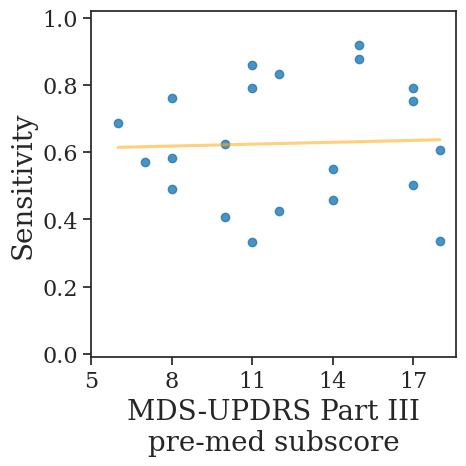

In [41]:
segment_length = 'short'

fig, ax = plt.subplots(figsize=(5,5))

print("Spearman correlation between subscore and sensitivity for ...\n")   
df_segment_specific = df_segment_subscore.loc[df_segment_subscore[f'{gc.columns.TRUE_SEGMENT_CAT}_duration']==segment_length].reset_index(drop=True)

sns.regplot(x='subscore', y='sens',
            data=df_segment_specific, ci=False, scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR},
            line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PwP',
            ax=ax)

rho = np.round(spearmanr(df_segment_specific['sens'], df_segment_specific['subscore']).correlation,2)
rho_p = np.round(spearmanr(df_segment_specific['sens'], df_segment_specific['subscore']).pvalue,2)

print(f"... {mp.segment_rename[segment_length].replace('$', '')} segments: {rho} (p={rho_p})")

# ax.set_title(f'{mp.segment_rename[segment_duration]} gait sequences')
ax.set_ylabel('Sensitivity')
ax.set_xlabel(f'MDS-UPDRS Part III\npre-med subscore')
ax.set_ylim([-0.01,1.02])

x_min, x_max = ax.get_xlim()
ax.set_xticks(np.arange(np.floor(x_min), np.ceil(x_max) + 1, step=3))  # Adjust step for finer ticks

        
fig.tight_layout()

plt.show()

Spearman correlation between subscore and sensitivity for ...

... Short [< 5s] segments: 0.07 (p=0.78)
... Moderately long [5 - 10s] segments: -0.23 (p=0.31)
... Long [10 - 20s] segments: 0.29 (p=0.2)
... Very long [\geq 20s] segments: -0.09 (p=0.71)


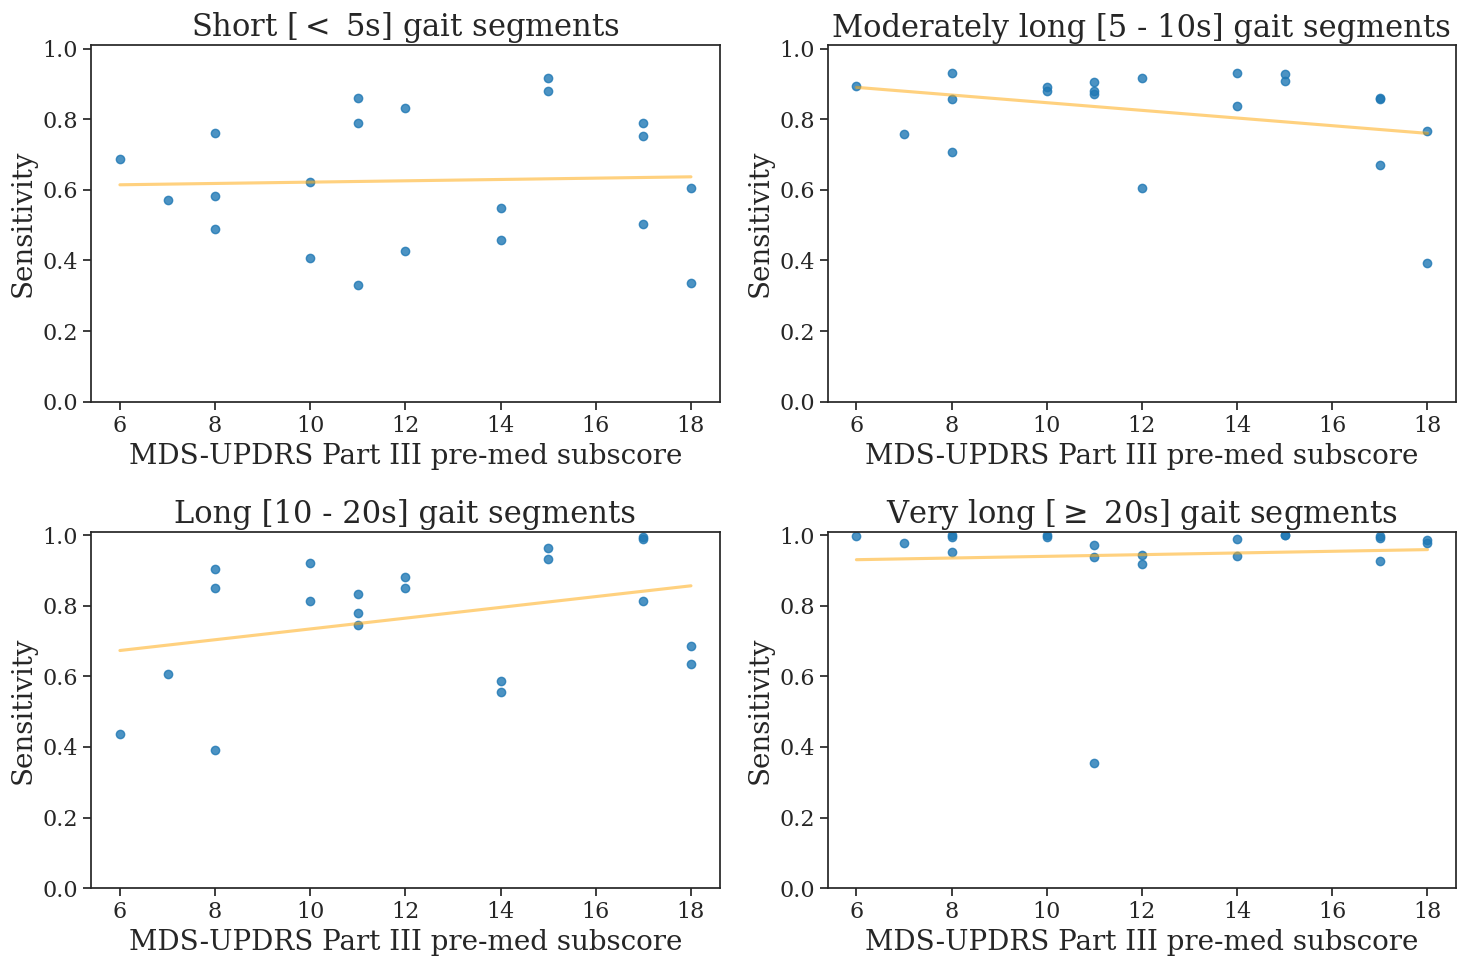

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

print("Spearman correlation between subscore and sensitivity for ...\n")
for j, segment_duration in enumerate(l_segment_categories):
    
    df_segment_specific = df_segment_subscore.loc[df_segment_subscore[f'{gc.columns.TRUE_SEGMENT_CAT}_duration']==segment_duration].reset_index(drop=True)

    sns.regplot(x='subscore', y='sens',
                data=df_segment_specific, ci=False, scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR},
                line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PwP',
                ax=ax[j//2,j%2])

    rho = np.round(spearmanr(df_segment_specific['sens'], df_segment_specific['subscore']).correlation,2)
    rho_p = np.round(spearmanr(df_segment_specific['sens'], df_segment_specific['subscore']).pvalue,2)

    print(f"... {mp.segment_rename[segment_duration].replace('$', '')} segments: {rho} (p={rho_p})")

    ax[j//2,j%2].set_title(f'{mp.segment_rename[segment_duration]} gait segments')
    ax[j//2,j%2].set_ylabel('Sensitivity')
    ax[j//2,j%2].set_xlabel(f'MDS-UPDRS Part III pre-med subscore')
    ax[j//2,j%2].set_ylim([0,1.01])
        
fig.tight_layout()
plt.show()

Tremor

In [51]:
l_ids_tremor_pre = [x for x in d_performance[gc.descriptives.PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED].keys() and 'no_tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED].keys()]
l_ids_tremor_post = [x for x in d_performance[gc.descriptives.PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED].keys() and 'no_tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED].keys()]

d_tremor = {
    'premed_tremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['tremor_spec'] for x in l_ids_tremor_pre],
    'premed_nontremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['no_tremor_spec'] for x in l_ids_tremor_pre],
    'postmed_tremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['tremor_spec'] for x in l_ids_tremor_post],
    'postmed_nontremor': [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['no_tremor_spec'] for x in l_ids_tremor_post]
}

print("Gait detection specificity during tremor vs no tremor")
print(f"P-value pre-med: {wilcoxon(d_tremor['premed_tremor'], d_tremor['premed_nontremor'])[1]}")
print(f"P-value post-med: {wilcoxon(d_tremor['postmed_tremor'], d_tremor['postmed_nontremor'])[1]}")

Gait detection specificity during tremor vs no tremor
P-value pre-med: 0.7421875
P-value post-med: 0.5625


In [52]:
df_tremor = pd.DataFrame()
l_tremor_bool = ['tremor', 'no_tremor']
d_pvals = {}

for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
    l_ids_tremor = [x for x in d_performance[gc.descriptives.PARKINSONS_DISEASE].keys() if 'tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage].keys() and 'no_tremor_spec' in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage].keys()]

    l_specs = []
    for tremor_bool in l_tremor_bool:
        
        spec = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.GAIT_DETECTION_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{tremor_bool}_spec'] for x in l_ids_tremor]
        l_specs.append(spec)

        df_tremor = pd.concat([df_tremor, pd.DataFrame([
                                med_stage,
                                tremor_bool,
                                f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                ]).T], axis=0).reset_index(drop=True)
        
    p_val = wilcoxon(l_specs[0], l_specs[1])[1]

    print(f"P-value {med_stage} gait detection specificity during tremor vs no tremor: {p_val}")
    
df_tremor.columns = ['Medication stage', 'Tremor boolean', 'Specificity']

df_tremor.pivot(index='Medication stage', columns='Tremor boolean', values=['Specificity']).sort_index(ascending=False)

P-value pre gait detection specificity during tremor vs no tremor: 0.7421875
P-value post gait detection specificity during tremor vs no tremor: 0.5625


Specificity             
Tremor boolean      no_tremor       tremor
Medication stage                          
pre               0.93 (0.04)  0.94 (0.06)
post              0.91 (0.06)    0.9 (0.1)